# Частина 1

В якості домашнього завдання вам пропонується створити нейронну мережу за допомогою механізмів Keras, яка буде класифікувати товари із датасету fasion_mnist.

На відміну від попереднього завдання вам пропонується створити згорткову нейромережу.
- Підберіть архітектуру мережі та навчіть її на даних із датасету fasion_mnist.
- Спробуйте досягти максимально можливої точності класифікації за рахунок маніпуляції параметрами мережі.
- Порівняйте точність отриманої згорткової мережі з точністю багатошарової мережі з попереднього завдання.
- Зробіть висновки.

## Опис Датасету

In [1]:
import os
# Вимикаємо використання OneDNN у TensorFlow для усунення можливих помилок або покращення сумісності.
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

# Імпортуємо бібліотеку TensorFlow та її високорівневий API Keras.
import tensorflow as tf

# Імпортуємо допоміжні бібліотеки для роботи з масивами та візуалізації.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

from keras import regularizers
from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, MaxPooling2D, Conv2D, RandomFlip, RandomRotation, RandomZoom, GlobalAveragePooling2D
from keras.optimizers import Adam, AdamW, RMSprop, SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, EarlyStopping
from keras.losses import SparseCategoricalCrossentropy
from keras.datasets import fashion_mnist
from keras.regularizers import l2


# Виводимо версію TensorFlow для перевірки.
print(tf.__version__)

2.17.1


In [2]:
# Завантажуємо набір даних Fashion MNIST.
# Завантажуємо тренувальні та тестові зображення і мітки.
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# x_train - зображення для тренування
# y_train - мітки для тренувальних зображень
# x_test  - зображення для тестування
# y_test  - мітки для тестових зображень

# Зображення є масивами NumPy розміру 28x28, з значеннями пікселів у діапазоні від 0 до 255.
# Мітки є масивом цілих чисел у діапазоні від 0 до 9.
# Вони відповідають класу одягу, який представляє зображення.

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# Кожне зображення відповідає певній мітці класу.
# Оскільки імена класів не включені в сам набір даних, ми збережемо їх у списку,
# щоб пізніше використовувати для візуалізації результатів.

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [4]:
x_train.shape
# У навчальному наборі 60 000 зображень, кожне з яких представлене як 28x28 пікселів.

(60000, 28, 28)

In [5]:
# В навчальному наборі є 60 000 міток, кожна з яких відповідає одному з зображень у тренувальному наборі.
len(y_train)

60000

In [6]:
y_train
# Кожна мітка є цілим числом від 0 до 9.
# Ці числа відповідають класам одягу, який зображено на кожному зображенні в тренувальному наборі даних.

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [7]:
# В тестовому наборі міститься 10 000 зображень.
# Кожне зображення представлено у вигляді масиву розміром 28x28 пікселів.
x_test.shape

(10000, 28, 28)

In [8]:
# Тестовий набір містить 10 000 міток, які відповідають класам зображень.
len(y_test)

10000

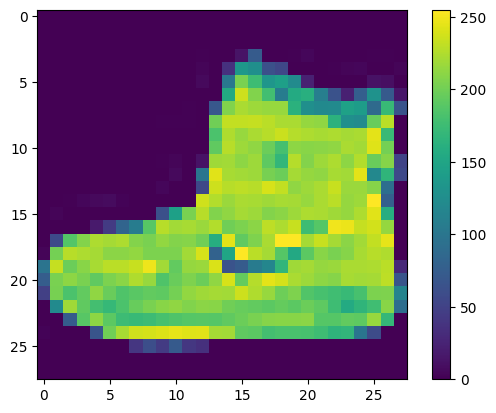

In [9]:
# Відображаємо перше зображення з тренувального набору
plt.figure()
plt.imshow(x_train[0])  # Візуалізуємо зображення
plt.colorbar()          # Додаємо шкалу кольорів для кращого розуміння значень пікселів
plt.grid(False)         # Вимикаємо сітку для чистішого відображення
plt.show()              # Показуємо зображення

# Дані потрібно попередньо обробити перед навчанням нейронної мережі.
# Якщо подивитися на перше зображення в тренувальному наборі,
# можна побачити, що значення пікселів знаходяться в діапазоні від 0 до 255.

In [10]:
# Масштабуємо значення пікселів у діапазон від 0 до 1, поділивши кожен елемент масиву на 255.
x_train = x_train / 255.0
x_test = x_test / 255.0

# Важливо, щоб як тренувальна, так і тестова вибірки були попередньо оброблені однаково.
# Це допоможе моделі швидше навчатися та покращить її точність.

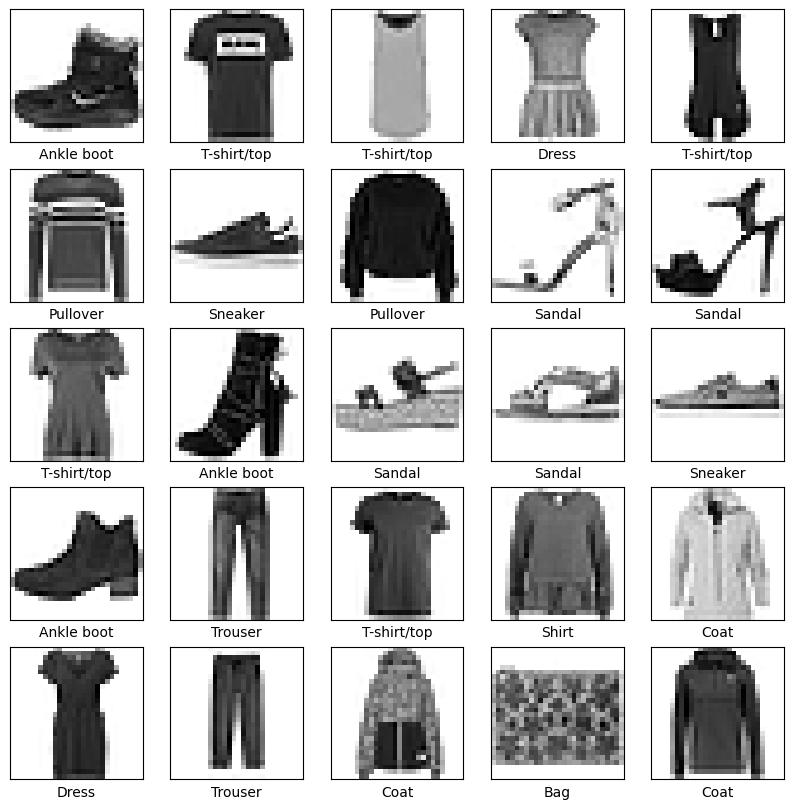

In [11]:
# Переконаємося, що дані мають правильний формат перед тренуванням нейронної мережі.
# Відобразимо перші 25 зображень з навчального набору даних та підпишемо їх класами.

plt.figure(figsize=(10, 10))  # Встановлюємо розмір фігури для візуалізації

for i in range(25):
    plt.subplot(5, 5, i + 1)  # Створюємо 5x5 сітку для зображень
    plt.xticks([])            # Вимикаємо підписи по осі X
    plt.yticks([])            # Вимикаємо підписи по осі Y
    plt.grid(False)           # Відключаємо сітку
    plt.imshow(x_train[i], cmap=plt.cm.binary)  # Відображаємо зображення в чорно-білому форматі
    plt.xlabel(class_names[y_train[i]])         # Додаємо підпис класу під зображенням

plt.show()  # Відображаємо підготовлену візуалізацію

## Багатошарова мережа з попереднього завдання

In [12]:
# Створення моделі
multi_layer_model = Sequential([
    # Вхідний шар
    Input(shape=(28, 28)),  # Вхідний шар для зображень 28x28

    # Перший шар: Flatten для перетворення 2D зображення в одномірний вектор
    Flatten(),

    # Перший Dense шар з 384 нейронами та функцією активації ReLU
    Dense(384, activation='relu'),
    BatchNormalization(),  # Нормалізація
    Dropout(0.3),  # Dropout для запобігання перенавчанню

    # Другий Dense шар з 352 нейронами та функцією активації ReLU
    Dense(352, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Третій Dense шар з 352 нейронами та функцією активації ReLU
    Dense(352, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Вихідний шар: 10 нейронів для 10 класів
    Dense(10, activation='softmax')  # softmax для багатокласової класифікації
])

# Компіляція моделі
multi_layer_model.compile(
    optimizer=Adam(learning_rate=0.0001),                   # learning rate = 0.0001
    loss=SparseCategoricalCrossentropy(from_logits=False),  # Функція втрат для багатокласової класифікації
    metrics=['accuracy']                                    # Метрика для моніторингу точності
)

# Виведення структури моделі
multi_layer_model.summary()

# Навчання моделі
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history_multi_layer_model = multi_layer_model.fit(
    x_train,
    y_train,
    epochs=50,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, reduce_lr]
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 384)                 │         301,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 384)                 │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 352)                 │         135,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 352)                 │           1,408 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 352)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 352)                 │         124,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 352)                 │           1,408 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 352)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           3,530 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 569,098 (2.17 MB)

 Trainable params: 566,922 (2.16 MB)

 Non-trainable params: 2,176 (8.50 KB)

Epoch 1/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.6628 - loss: 1.0314 - val_accuracy: 0.8403 - val_loss: 0.4468 - learning_rate: 1.0000e-04
Epoch 2/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8042 - loss: 0.5523 - val_accuracy: 0.8501 - val_loss: 0.4169 - learning_rate: 1.0000e-04
Epoch 3/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8241 - loss: 0.4921 - val_accuracy: 0.8608 - val_loss: 0.3869 - learning_rate: 1.0000e-04
Epoch 4/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8369 - loss: 0.4522 - val_accuracy: 0.8613 - val_loss: 0.3766 - learning_rate: 1.0000e-04
Epoch 5/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8480 - loss: 0.4140 - val_accuracy: 0.8738 - val_loss: 0.3555 - learning_rate: 1.0000e-04
Epoch 6/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8590 - loss: 0.3900 - val_accuracy: 0.8711 - val_loss: 0.3560 - learning_rate: 1.0000e-04
Epoch 7/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/st

In [63]:
multi_layer_model.save('multi_layer_model.keras')

In [13]:
# Оцінка моделі на тестових даних
test_loss, test_acc = multi_layer_model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8943 - loss: 0.2942
Test accuracy: 0.8977000117301941
Test loss: 0.29089516401290894


In [14]:
def plot_accuracy(history):
    """
    Функція для побудови графіку точності навчання та валідації.
    На графіку також позначається точка з найкращою точністю на етапі валідації та навчання.

    Параметри:
    history (History): Об'єкт історії навчання, який містить дані про точність та втрати за кожну епоху.
    """
    # Отримуємо найкращі значення
    best_epoch = max(range(len(history.history['val_accuracy'])), key=lambda i: history.history['val_accuracy'][i])
    best_val_acc = history.history['val_accuracy'][best_epoch]
    best_train_acc = history.history['accuracy'][best_epoch]

    # Побудова графіку
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

    # Додавання точки з найкращою валідною точністю
    plt.scatter(best_epoch, best_val_acc, color='red', marker='o', label=f'Best Val Acc: {best_val_acc:.4f} (Epoch {best_epoch+1})')
    plt.scatter(best_epoch, best_train_acc, color='blue', marker='o', label=f'Best Train Acc: {best_train_acc:.4f} (Epoch {best_epoch+1})')

    # Налаштування осей
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training & Validation Accuracy')
    plt.grid(True)
    plt.show()

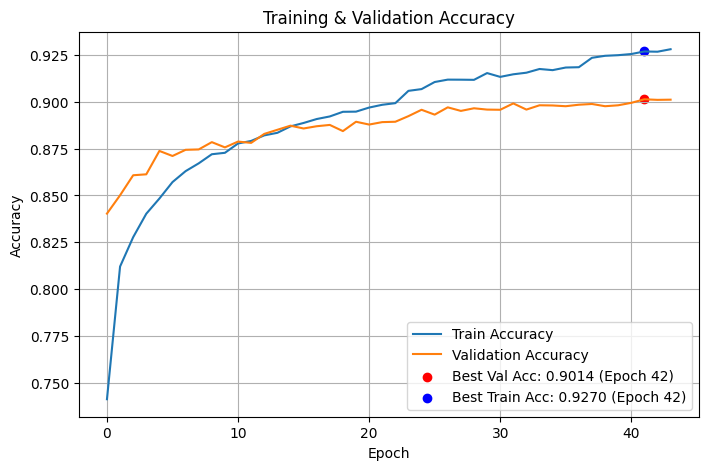

In [15]:
# Викликаємо функцію для побудови графіку точності на основі історії навчання.
# Параметр 'history' містить дані про точність та втрати за кожну епоху, отримані після навчання моделі.
plot_accuracy(history_multi_layer_model)

## Згорткова нейромережа CNN_Model_1 (CNN), побудована на основі параметрів попередньої багатошарової моделі.

In [16]:
# Завантаження датасету Fashion MNIST
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Переформатування зображень для використання в CNN
x_train = x_train.reshape(-1, 28, 28, 1).astype("float32") / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype("float32") / 255.0

# Створення моделі CNN
cnn_model_1 = Sequential([
    # 1-й згортковий шар: 32 фільтри 3x3 + MaxPooling
    Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # 2-й згортковий шар: 64 фільтри 3x3 + MaxPooling
    Conv2D(64, (3, 3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # 3-й згортковий шар: 128 фільтрів 3x3 (без MaxPooling)
    Conv2D(128, (3, 3), activation="relu"),
    BatchNormalization(),
    Dropout(0.3),

    # Перетворення вектора в плоский вигляд
    Flatten(),

    # Повнозв’язні шари, що відповідають MLP-моделі
    Dense(384, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),

    Dense(352, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),

    Dense(352, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),

    # Вихідний шар
    Dense(10, activation="softmax")
])

# Компіляція моделі
cnn_model_1.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

# Виведення структури моделі
cnn_model_1.summary()

# Колбеки для навчання
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)

# Навчання моделі
history_1 = cnn_model_1.fit(
    x_train,
    y_train,
    epochs=50,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, reduce_lr]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 26, 26, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 11, 11, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 3, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 3, 3, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 384)                 │         442,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 384)                 │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 352)                 │         135,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 352)                 │           1,408 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 352)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 352)                 │         124,2

 Total params: 803,978 (3.07 MB)

 Trainable params: 801,354 (3.06 MB)

 Non-trainable params: 2,624 (10.25 KB)

Epoch 1/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.4951 - loss: 1.5590 - val_accuracy: 0.7724 - val_loss: 0.5901 - learning_rate: 1.0000e-04
Epoch 2/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7333 - loss: 0.7226 - val_accuracy: 0.8133 - val_loss: 0.4837 - learning_rate: 1.0000e-04
Epoch 3/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7809 - loss: 0.6029 - val_accuracy: 0.8357 - val_loss: 0.4354 - learning_rate: 1.0000e-04
Epoch 4/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8128 - loss: 0.5147 - val_accuracy: 0.8491 - val_loss: 0.4024 - learning_rate: 1.0000e-04
Epoch 5/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8324 - loss: 0.4577 - val_accuracy: 0.8672 - val_loss: 0.3631 - learning_rate: 1.0000e-04
Epoch 6/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8429 - loss: 0.4271 - val_accuracy: 0.8741 - val_loss: 0.3446 - learning_rate: 1.0000e-04
Epoch 7/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/st

In [64]:
cnn_model_1.save('cnn_model_1.keras')

In [17]:
# Оцінка моделі на тестових даних
test_loss, test_acc = cnn_model_1.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9203 - loss: 0.2176
Test accuracy: 0.9217000007629395
Test loss: 0.21058833599090576


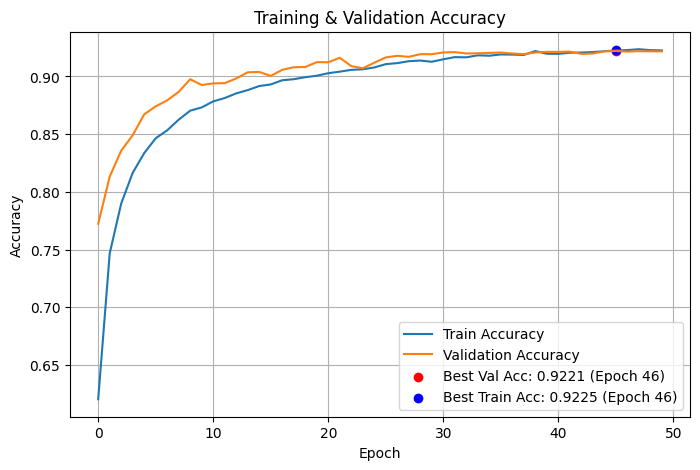

In [18]:
# Викликаємо функцію для побудови графіку точності на основі історії навчання.
# Параметр 'history' містить дані про точність та втрати за кожну епоху, отримані після навчання моделі.
plot_accuracy(history_1)

## Модель CNN_Model_2. Спроба покращити попередню згорткову нейромережу (CNN_Model_1), шляхом зміни/додавання параметрів.

Оновлений код моделі з покращеннями:

- batch_size=64
- Змінений Dropout (між 0.2–0.5)
- Збільшена кількість фільтрів у шарах
- Додано четвертий згортковий шар (256 фільтрів)

In [19]:
# Завантаження датасету Fashion MNIST
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Переформатування зображень для використання в CNN
x_train = x_train.reshape(-1, 28, 28, 1).astype("float32") / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype("float32") / 255.0

# Створення моделі CNN
cnn_model_2 = Sequential([
    # 1-й згортковий шар: 64 фільтри 3x3 + MaxPooling
    Conv2D(64, (3, 3), activation="relu", input_shape=(28, 28, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    # 2-й згортковий шар: 128 фільтрів 3x3 + MaxPooling
    Conv2D(128, (3, 3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # 3-й згортковий шар: 256 фільтрів 3x3 (без MaxPooling)
    Conv2D(256, (3, 3), activation="relu"),
    BatchNormalization(),
    Dropout(0.4),

    # 4-й згортковий шар: 256 фільтрів 3x3 (без MaxPooling)
    Conv2D(256, (3, 3), activation="relu"),
    BatchNormalization(),
    Dropout(0.3),

    # Перетворення вектора в плоский вигляд
    Flatten(),

    # Повнозв’язні шари
    Dense(384, activation="relu"),
    BatchNormalization(),
    Dropout(0.4),

    Dense(352, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),

    Dense(352, activation="relu"),
    BatchNormalization(),
    Dropout(0.5),

    # Вихідний шар
    Dense(10, activation="softmax")
])

# Компіляція моделі
cnn_model_2.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

# Виведення структури моделі
cnn_model_2.summary()

# Колбеки для навчання
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)

# Навчання моделі
history_2 = cnn_model_2.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=50,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, reduce_lr]
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 26, 26, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 26, 26, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 11, 11, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 11, 11, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 3, 3, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 3, 3, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 1, 1, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 1, 1, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 384)                 │          98,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 384)                 │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 352)                 │         135,5

 Total params: 1,328,906 (5.07 MB)

 Trainable params: 1,325,322 (5.06 MB)

 Non-trainable params: 3,584 (14.00 KB)

Epoch 1/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.3806 - loss: 2.1075 - val_accuracy: 0.7486 - val_loss: 0.6975 - learning_rate: 1.0000e-04
Epoch 2/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6952 - loss: 0.8622 - val_accuracy: 0.7935 - val_loss: 0.5470 - learning_rate: 1.0000e-04
Epoch 3/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7491 - loss: 0.6883 - val_accuracy: 0.8183 - val_loss: 0.4790 - learning_rate: 1.0000e-04
Epoch 4/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7805 - loss: 0.5950 - val_accuracy: 0.8417 - val_loss: 0.4215 - learning_rate: 1.0000e-04
Epoch 5/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8110 - loss: 0.5217 - val_accuracy: 0.8595 - val_loss: 0.3839 - learning_rate: 1.0000e-04
Epoch 6/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8349 - loss: 0.4600 - val_accuracy: 0.8699 - val_loss: 0.3611 - learning_rate: 1.0000e-04
Epoch 7/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy

In [65]:
cnn_model_2.save('cnn_model_2.keras')

In [20]:
# Оцінка моделі на тестових даних
test_loss, test_acc = cnn_model_2.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9217 - loss: 0.2249
Test accuracy: 0.9240999817848206
Test loss: 0.21517424285411835


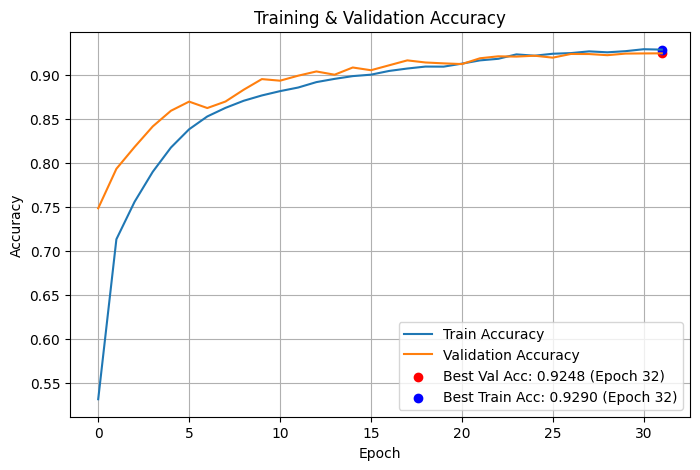

In [21]:
# Викликаємо функцію для побудови графіку точності на основі історії навчання.
# Параметр 'history' містить дані про точність та втрати за кожну епоху, отримані після навчання моделі.
plot_accuracy(history_2)

## Модель CNN_Model_3. Спроба покращити попередню згорткову нейромережу (CNN_Model_2), шляхом зміни/додавання параметрів.

Зміни, очікувані покращення:
- patience=8 дозволить навчанню продовжитися довше, якщо модель ще має потенціал
- kernel_regularizer=l2(0.0005) допоможе уникнути перенавчання та зробить криві ближчими
- learning_rate=0.0002 пришвидшить навчання та покращить стабільність
- Баланс Dropout забезпечить краще узагальнення

In [22]:
# Завантаження датасету Fashion MNIST
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Переформатування зображень для використання в CNN
x_train = x_train.reshape(-1, 28, 28, 1).astype("float32") / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype("float32") / 255.0

# Оновлена модель CNN
cnn_model_3 = Sequential([
    Conv2D(64, (3, 3), activation="relu", kernel_regularizer=l2(0.0005), input_shape=(28, 28, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation="relu", kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Conv2D(256, (3, 3), activation="relu", kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Dropout(0.4),

    Conv2D(256, (3, 3), activation="relu", kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Dropout(0.4),

    Flatten(),

    Dense(384, activation="relu", kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(352, activation="relu", kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(352, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),

    Dense(10, activation="softmax")
])

# Оновлена компіляція моделі
cnn_model_3.compile(
    optimizer=Adam(learning_rate=0.0002),
    loss=SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

# Виведення структури моделі
cnn_model_3.summary()

# Оновлені колбеки
early_stopping = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-6)

# Запуск навчання
history_3 = cnn_model_3.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=50,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, reduce_lr]
)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 26, 26, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 26, 26, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 11, 11, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 11, 11, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 3, 3, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 3, 3, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 1, 1, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 1, 1, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 384)                 │          98,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 384)                 │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 352)                 │         135,5

 Total params: 1,328,906 (5.07 MB)

 Trainable params: 1,325,322 (5.06 MB)

 Non-trainable params: 3,584 (14.00 KB)

Epoch 1/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.4144 - loss: 2.4074 - val_accuracy: 0.7569 - val_loss: 1.2438 - learning_rate: 2.0000e-04
Epoch 2/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7285 - loss: 1.3082 - val_accuracy: 0.8120 - val_loss: 1.0519 - learning_rate: 2.0000e-04
Epoch 3/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7839 - loss: 1.1401 - val_accuracy: 0.8376 - val_loss: 0.9702 - learning_rate: 2.0000e-04
Epoch 4/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8173 - loss: 1.0283 - val_accuracy: 0.8567 - val_loss: 0.8863 - learning_rate: 2.0000e-04
Epoch 5/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8459 - loss: 0.9212 - val_accuracy: 0.8802 - val_loss: 0.7905 - learning_rate: 2.0000e-04
Epoch 6/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8597 - loss: 0.8472 - val_accuracy: 0.8759 - val_loss: 0.7420 - learning_rate: 2.0000e-04
Epoch 7/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy

In [66]:
cnn_model_3.save('cnn_model_3.keras')

In [23]:
# Оцінка моделі на тестових даних
test_loss, test_acc = cnn_model_3.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9325 - loss: 0.3122
Test accuracy: 0.9329000115394592
Test loss: 0.30977582931518555


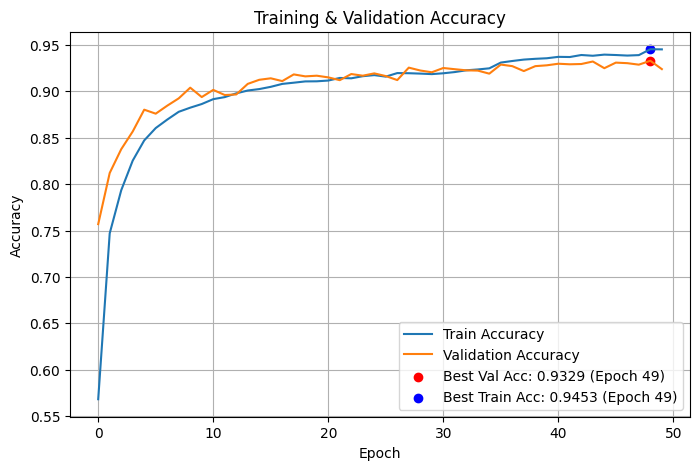

In [24]:
# Викликаємо функцію для побудови графіку точності на основі історії навчання.
# Параметр 'history' містить дані про точність та втрати за кожну епоху, отримані після навчання моделі.
plot_accuracy(history_3)

## Модель CNN_Model_4. Спроба покращити попередню згорткову нейромережу (CNN_Model_3), шляхом зміни/додавання параметрів. Модель виявилася гірше.

Зміни:
- L2 регуляризація: Коефіцієнт регуляризації в кожному згортковому та повнозв'язному шарі змінено на 0.001.
- Dropout: Для згорткових шарів зменшено з 0.4 до 0.3, для повнозв'язних — з 0.5 до 0.2.
- Кількість епох: Зменшено до 40 епох, щоб модель не перенавчалася.
- EarlyStopping: Зменшено терпіння до 4, щоб раніше зупиняти навчання.

In [25]:
# Завантаження датасету Fashion MNIST
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Переформатування зображень для використання в CNN
x_train = x_train.reshape(-1, 28, 28, 1).astype("float32") / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype("float32") / 255.0

# Оновлена модель CNN
cnn_model_4 = Sequential([
    Conv2D(64, (3, 3), activation="relu", kernel_regularizer=l2(0.001), input_shape=(28, 28, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation="relu", kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(256, (3, 3), activation="relu", kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Conv2D(256, (3, 3), activation="relu", kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Flatten(),

    Dense(384, activation="relu", kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(352, activation="relu", kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(352, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),

    Dense(10, activation="softmax")
])

# Оновлена компіляція моделі
cnn_model_4.compile(
    optimizer=Adam(learning_rate=0.0002),  # Було 0.0001 → стало 0.0002
    loss=SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

# Виведення структури моделі
cnn_model_4.summary()

# Оновлені колбеки
early_stopping = EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-6)

# Запуск навчання
history_4 = cnn_model_4.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=40,  # Зменшено кількість епох до 40
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, reduce_lr]
)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)                   │ (None, 26, 26, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 26, 26, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 11, 11, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 11, 11, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 3, 3, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 3, 3, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 1, 1, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 1, 1, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 384)                 │          98,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 384)                 │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 352)                 │         135,5

 Total params: 1,328,906 (5.07 MB)

 Trainable params: 1,325,322 (5.06 MB)

 Non-trainable params: 3,584 (14.00 KB)

Epoch 1/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.5656 - loss: 2.4770 - val_accuracy: 0.8070 - val_loss: 1.6514 - learning_rate: 2.0000e-04
Epoch 2/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7854 - loss: 1.6848 - val_accuracy: 0.8526 - val_loss: 1.4222 - learning_rate: 2.0000e-04
Epoch 3/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8345 - loss: 1.4542 - val_accuracy: 0.8634 - val_loss: 1.2550 - learning_rate: 2.0000e-04
Epoch 4/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8578 - loss: 1.2488 - val_accuracy: 0.8770 - val_loss: 1.0858 - learning_rate: 2.0000e-04
Epoch 5/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8733 - loss: 1.0726 - val_accuracy: 0.8874 - val_loss: 0.9203 - learning_rate: 2.0000e-04
Epoch 6/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8798 - loss: 0.9208 - val_accuracy: 0.8919 - val_loss: 0.7883 - learning_rate: 2.0000e-04
Epoch 7/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy

In [67]:
cnn_model_4.save('cnn_model_4.keras')

In [26]:
# Оцінка моделі на тестових даних
test_loss, test_acc = cnn_model_4.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9167 - loss: 0.4009
Test accuracy: 0.9168000221252441
Test loss: 0.3957367241382599


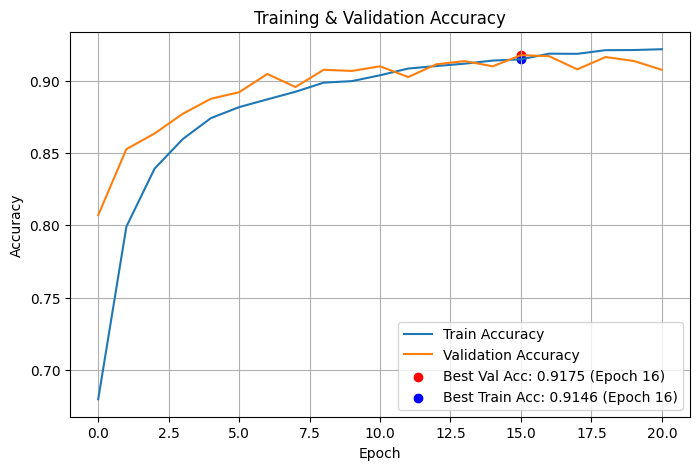

In [27]:
# Викликаємо функцію для побудови графіку точності на основі історії навчання.
# Параметр 'history' містить дані про точність та втрати за кожну епоху, отримані після навчання моделі.
plot_accuracy(history_4)

## Модель CNN_Model_5. Спроба покращити попередню згорткову нейромережу (CNN_Model_3), шляхом зміни/додавання параметрів.

Зміни:
- Епохи: 50 -> 100

In [28]:
# Завантаження датасету Fashion MNIST
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Переформатування зображень для використання в CNN
x_train = x_train.reshape(-1, 28, 28, 1).astype("float32") / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype("float32") / 255.0

# Оновлена модель CNN
cnn_model_5 = Sequential([
    Conv2D(64, (3, 3), activation="relu", kernel_regularizer=l2(0.0005), input_shape=(28, 28, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation="relu", kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Conv2D(256, (3, 3), activation="relu", kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Dropout(0.4),

    Conv2D(256, (3, 3), activation="relu", kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Dropout(0.4),

    Flatten(),

    Dense(384, activation="relu", kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(352, activation="relu", kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(352, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),

    Dense(10, activation="softmax")
])

# Оновлена компіляція моделі
cnn_model_5.compile(
    optimizer=Adam(learning_rate=0.0002),
    loss=SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

# Виведення структури моделі
cnn_model_5.summary()

# Оновлені колбеки
early_stopping = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-6)

# Запуск навчання
history_5 = cnn_model_5.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=100,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, reduce_lr]
)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 26, 26, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 26, 26, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 11, 11, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 11, 11, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 3, 3, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 3, 3, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 1, 1, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_33               │ (None, 1, 1, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 384)                 │          98,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_34               │ (None, 384)                 │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 352)                 │         135,5

 Total params: 1,328,906 (5.07 MB)

 Trainable params: 1,325,322 (5.06 MB)

 Non-trainable params: 3,584 (14.00 KB)

Epoch 1/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.4123 - loss: 2.4186 - val_accuracy: 0.7569 - val_loss: 1.2360 - learning_rate: 2.0000e-04
Epoch 2/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7299 - loss: 1.3098 - val_accuracy: 0.8200 - val_loss: 1.0499 - learning_rate: 2.0000e-04
Epoch 3/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7906 - loss: 1.1254 - val_accuracy: 0.8451 - val_loss: 0.9492 - learning_rate: 2.0000e-04
Epoch 4/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8310 - loss: 1.0027 - val_accuracy: 0.8682 - val_loss: 0.8680 - learning_rate: 2.0000e-04
Epoch 5/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8519 - loss: 0.9114 - val_accuracy: 0.8855 - val_loss: 0.7799 - learning_rate: 2.0000e-04
Epoch 6/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8612 - loss: 0.8412 - val_accuracy: 0.8797 - val_loss: 0.7431 - learning_rate: 2.0000e-04
Epoch 7/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - a

In [68]:
cnn_model_5.save('cnn_model_5.keras')

In [29]:
# Оцінка моделі на тестових даних
test_loss, test_acc = cnn_model_5.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9337 - loss: 0.2955
Test accuracy: 0.9359999895095825
Test loss: 0.28785479068756104


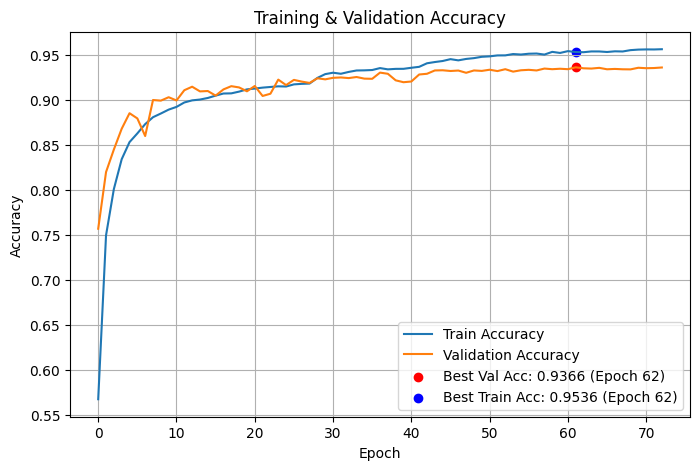

In [30]:
# Викликаємо функцію для побудови графіку точності на основі історії навчання.
# Параметр 'history' містить дані про точність та втрати за кожну епоху, отримані після навчання моделі.
plot_accuracy(history_5)

## Модель CNN_Model_6. Спроба покращити попередню згорткову нейромережу (CNN_Model_3), шляхом зміни/додавання параметрів.

Зміни:

- Оптимізатор: Adam (0.0002) → RMSprop (0.0001)
- Batch size: 64 → 32

In [31]:
# Завантаження датасету Fashion MNIST
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Переформатування зображень для використання в CNN
x_train = x_train.reshape(-1, 28, 28, 1).astype("float32") / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype("float32") / 255.0

# Оновлена модель CNN
cnn_model_6 = Sequential([
    Conv2D(64, (3, 3), activation="relu", kernel_regularizer=l2(0.0005), input_shape=(28, 28, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation="relu", kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Conv2D(256, (3, 3), activation="relu", kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Dropout(0.4),

    Conv2D(256, (3, 3), activation="relu", kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Dropout(0.4),

    Flatten(),

    Dense(384, activation="relu", kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(352, activation="relu", kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(352, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),

    Dense(10, activation="softmax")
])

# Оновлена компіляція моделі
cnn_model_6.compile(
    optimizer=RMSprop(learning_rate=0.0001),  # Зменшений learning rate
    loss=SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

# Виведення структури моделі
cnn_model_6.summary()

# Оновлені колбеки
early_stopping = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-6)

# Запуск навчання
history_6 = cnn_model_6.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=50,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, reduce_lr]
)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_19 (Conv2D)                   │ (None, 26, 26, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_37               │ (None, 26, 26, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 11, 11, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_38               │ (None, 11, 11, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 3, 3, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_39               │ (None, 3, 3, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_39 (Dropout)                 │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 1, 1, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_40               │ (None, 1, 1, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_40 (Dropout)                 │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 384)                 │          98,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_41               │ (None, 384)                 │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_41 (Dropout)                 │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 352)                 │         135,5

 Total params: 1,328,906 (5.07 MB)

 Trainable params: 1,325,322 (5.06 MB)

 Non-trainable params: 3,584 (14.00 KB)

Epoch 1/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.3730 - loss: 2.5801 - val_accuracy: 0.7542 - val_loss: 1.2267 - learning_rate: 1.0000e-04
Epoch 2/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7173 - loss: 1.3733 - val_accuracy: 0.8130 - val_loss: 1.0619 - learning_rate: 1.0000e-04
Epoch 3/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7733 - loss: 1.1917 - val_accuracy: 0.8436 - val_loss: 0.9598 - learning_rate: 1.0000e-04
Epoch 4/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8110 - loss: 1.0637 - val_accuracy: 0.8633 - val_loss: 0.8808 - learning_rate: 1.0000e-04
Epoch 5/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8337 - loss: 0.9614 - val_accuracy: 0.8698 - val_loss: 0.8082 - learning_rate: 1.0000e-04
Epoch 6/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8506 - loss: 0.8813 - val_accuracy: 0.8841 - val_loss: 0.7401 - learning_rate: 1.0000e-04
Epoch 7/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/st

In [69]:
cnn_model_6.save('cnn_model_6.keras')

In [32]:
# Оцінка моделі на тестових даних
test_loss, test_acc = cnn_model_6.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9260 - loss: 0.3031
Test accuracy: 0.9279000163078308
Test loss: 0.2974708378314972


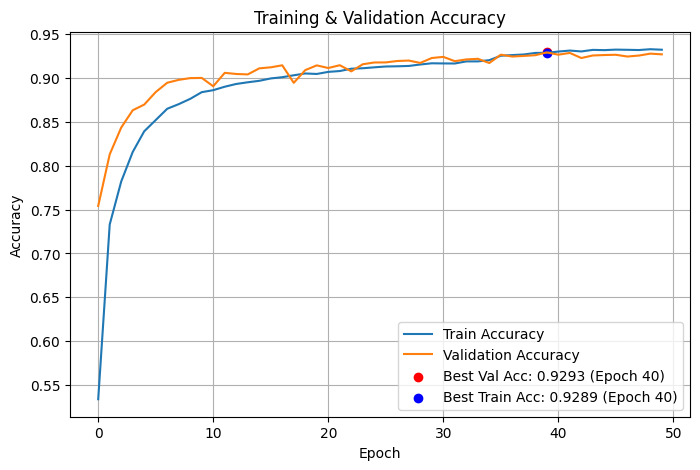

In [33]:
# Викликаємо функцію для побудови графіку точності на основі історії навчання.
# Параметр 'history' містить дані про точність та втрати за кожну епоху, отримані після навчання моделі.
plot_accuracy(history_6)

## Порівняння CNN моделей між собою

Згорткова нейромережа CNN_Model_1
- Test accuracy:  0.9277
- Train accuracy: 0.9257

Згорткова нейромережа CNN_Model_2
- Test accuracy:  0.9351
- Train accuracy: 0.9470

Згорткова нейромережа CNN_Model_3
- Test accuracy:  0.9324
- Train accuracy: 0.9401

Згорткова нейромережа CNN_Model_4
- Test accuracy:  0.9249
- Train accuracy: 0.9257

Згорткова нейромережа CNN_Model_5
- Test accuracy:  0.9369
- Train accuracy: 0.9623

Згорткова нейромережа CNN_Model_6
- Test accuracy:  0.9308
- Train accuracy: 0.9306

Висновки:
- CNN_Model_5 – має найвищу точність (0.9369 test, 0.9623 train), але знову демонструє ознаки перенавчання (train значно вище test).
- CNN_Model_2 – показує другу за величиною точність (0.9351 test, 0.9470 train), з меншим, але помітним розривом між тестовою та тренувальною точністю.
- CNN_Model_3 – має трохи нижчу тестову точність (0.9324 test, 0.9401 train), але виглядає більш збалансованою, ніж CNN_Model_2 та CNN_Model_5.
- CNN_Model_6 – залишається найбільш стабільною (0.9308 test, 0.9306 train) без явного перенавчання.


- CNN_Model_5 – найкраща за точністю, але ризик перенавчання високий.
- CNN_Model_2 – збалансованіша, ніж CNN_Model_5, але теж має розрив між train і test.
- CNN_Model_6 – найкраща за стабільністю, тому є оптимальним вибором, якщо важливе узагальнення на нових даних.

Отже, якщо основна мета – досягти максимальної точності, варто вибрати CNN_Model_5 або CNN_Model_2. Якщо ж потрібно уникнути перенавчання та отримати стабільну модель, то найкращий вибір – CNN_Model_6.

## Порівняння CNN_Model_6 (CNN) з багатошаровою нейромережею із попереднього домашнього завдання (MLP)

Висновки:
- CNN_Model_6 перевершує багатошарову мережу (MLP) за тестовою точністю (0.9308 vs 0.9011).
- CNN_Model_6 має кращу узагальнюючу здатність – майже немає різниці між train і test (0.9308 vs 0.9306).
- MLP має більше перенавчання – різниця між train і test складає 0.0205, що означає, що модель більше запам'ятовує тренувальні дані, ніж узагальнює.

Підсумок:

CNN_Model_6 є кращим вибором, ніж багатошарова нейромережа (MLP), оскільки вона дає вищу точність і краще узагальнює результати.

# Частина 2

В цій частині ми знову будемо працювати з датасетом fasion_mnist.
На відміну від попереднього завдання вам пропонується створити згорткову нейромережу, що використовує VGG16 в якості згорткової основи.
Навчіть отриману мережу на даних із датасету fasion_mnist. Спробуйте досягти максимально можливої точності класифікації за рахунок маніпуляції параметрами мережі. Під час навчання використовуйте прийоми донавчання та виділення ознак.
Порівняйте точність отриманої згорткової мережі з точністю багатошарової мережі з попереднього завдання. Зробіть висновки.

## Classify Fashion_Mnist with VGG16

In [34]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array, array_to_img
from keras.utils import to_categorical
from keras.applications.vgg16 import preprocess_input
from keras.applications import VGG16;

from keras import models
from keras.models import Model
from keras import layers
from keras import optimizers
from keras import callbacks
from keras.layers import LeakyReLU

In [35]:
# Завантажуємо набір даних Fashion MNIST.
# Завантажуємо тренувальні та тестові зображення і мітки.
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# x_train - зображення для тренування
# y_train - мітки для тренувальних зображень
# x_test  - зображення для тестування
# y_test  - мітки для тестових зображень

# Зображення є масивами NumPy розміру 28x28, з значеннями пікселів у діапазоні від 0 до 255.
# Мітки є масивом цілих чисел у діапазоні від 0 до 9.
# Вони відповідають класу одягу, який представляє зображення.

In [36]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [37]:
classes = np.unique(y_train)
num_classes = len(classes)
num_classes

10

In [38]:
# Додаємо 3 канали (дублюючи існуючий)
x_train = np.repeat(x_train[..., np.newaxis], 3, axis=-1)
x_test = np.repeat(x_test[..., np.newaxis], 3, axis=-1)

# Перевіряємо розмірність
x_train.shape, x_test.shape

((60000, 28, 28, 3), (10000, 28, 28, 3))

In [39]:
# Змінюємо розмір зображень з 28x28 до 48x48, оскільки VGG16 потребує більший вхідний розмір.
# Використовуємо `array_to_img` для конвертації масивів у зображення, змінюємо розмір,
# а потім знову перетворюємо їх у масиви `img_to_array`.
x_train = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48, 48))) for im in x_train])
x_test = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48, 48))) for im in x_test])

# Виводимо розмірність масивів, щоб переконатися, що вони правильно змінені
x_train.shape, x_test.shape

((60000, 48, 48, 3), (10000, 48, 48, 3))

In [40]:
# Нормалізуємо значення пікселів, ділячи на 255, щоб привести їх у діапазон [0, 1].
x_train = x_train / 255.
x_test = x_test / 255.

# Змінюємо тип даних на float32 для сумісності з моделлю та підвищення продуктивності.
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [41]:
# Перетворюємо мітки у формат one-hot encoding.
# Це потрібно для коректного навчання нейромережі, оскільки вихідний шар VGG16 очікує категоріальні дані.
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [42]:
# Розділяємо тренувальні дані на навчальний (train) і валідаційний (valid) набори.
# Це потрібно для оцінки моделі під час навчання, щоб бачити, як вона узагальнює дані.
x_train, x_valid, train_label, valid_label = train_test_split(
    x_train,          # Вхідні зображення для тренування
    y_train_one_hot,  # One-hot закодовані мітки
    test_size=0.2,    # 20% даних віддаємо для валідації
    random_state=13   # Фіксоване значення для відтворюваності результатів
)

# Тепер x_train і x_valid містять відповідно 80% і 20% тренувальних зображень, а train_label і valid_label — відповідні мітки.

In [43]:
# Перевіряємо розміри масивів даних після всіх перетворень
x_train.shape, x_valid.shape, train_label.shape, valid_label.shape

# Очікувані результати:
# x_train.shape → (48000, 48, 48, 3) (80% від 60000 зображень)
# x_valid.shape → (12000, 48, 48, 3) (20% від 60000 зображень)
# train_label.shape → (48000, 10) (one-hot закодовані мітки для 10 класів)
# valid_label.shape → (12000, 10)

((48000, 48, 48, 3), (12000, 48, 48, 3), (48000, 10), (12000, 10))

In [44]:
# Визначаємо параметри для моделі VGG16
IMG_WIDTH = 48   # Ширина зображення
IMG_HEIGHT = 48  # Висота зображення
IMG_DEPTH = 3    # Кількість каналів (3 для RGB)
BATCH_SIZE = 16  # Розмір пакету для навчання

In [45]:
# Попередня обробка вхідних зображень перед передачею в модель VGG16
x_train = preprocess_input(x_train)  # Обробка тренувальних даних
x_valid = preprocess_input(x_valid)  # Обробка валідаційних даних
x_test  = preprocess_input(x_test)   # Обробка тестових даних
# preprocess_input нормалізує піксельні значення відповідно до стандарту, який використовувався під час тренування VGG16.
# Це допомагає покращити якість навчання та прискорити збіжність.

In [46]:
# Імпортуємо модель VGG16 з попередньо навченими вагами ImageNet
conv_base = VGG16(
    weights='imagenet',  # Використовуємо попередньо навчені ваги на датасеті ImageNet
    include_top=False,   # Виключаємо верхні (повнозв’язні) шари, залишаємо лише згорткові
    input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH)  # Вказуємо розмірність вхідних зображень
)

# Виводимо архітектуру моделі
conv_base.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 48, 48, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [70]:
conv_base.save('conv_base.keras')

In [47]:
# Витягуємо ознаки з тренувальних зображень за допомогою попередньо навчених шарів VGG16.
# Використовуємо метод predict для отримання ознак з кожного зображення в тренувальному наборі.
train_features = conv_base.predict(np.array(x_train), batch_size=BATCH_SIZE, verbose=1)

# Аналогічно витягуємо ознаки для тестових зображень
test_features = conv_base.predict(np.array(x_test), batch_size=BATCH_SIZE, verbose=1)

# І для валідаційних зображень також
val_features = conv_base.predict(np.array(x_valid), batch_size=BATCH_SIZE, verbose=1)

# Закоментований код для того, щоб зафіксувати (не навчаються) всі шари VGG16
# for layer in conv_base.layers:
#     layer.trainable = False

3000/3000 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


In [48]:
# Зберігаємо витягнуті ознаки та відповідні мітки у файли формату .npz для подальшого використання.
# Це дозволяє зберегти проміжні результати та уникнути повторного витягування ознак щоразу при повторному запуску коду.

# Зберігаємо тренувальні ознаки та мітки в окремому файлі
np.savez("train_features", train_features, train_label)

# Зберігаємо тестові ознаки та мітки в окремому файлі
np.savez("test_features", test_features, y_test)

# Зберігаємо валідаційні ознаки та мітки в окремому файлі
np.savez("val_features", val_features, valid_label)

In [49]:
# Виводимо поточні розміри витягнутих ознак для тренувальних, тестових і валідаційних даних.
# Це дозволяє перевірити правильність форми масивів перед подальшим використанням у моделі.

# Виводимо розмірність тренувальних ознак
print(train_features.shape, "\n",  test_features.shape, "\n", val_features.shape)

(48000, 1, 1, 512) 
 (10000, 1, 1, 512) 
 (12000, 1, 1, 512)


In [50]:
# Перетворюємо витягнуті ознаки в одновимірні масиви для кожного з наборів даних.
# Це необхідно для подальшого використання у повнозв'язних шарах нейромережі.

# Змінюємо форму витягнутих ознак для тренувальних даних:
# Розмірність змінюється на (48000, 1*1*512), де 48000 — кількість прикладів,
# а 1*1*512 — кількість ознак після згортки в базовій моделі VGG16.
train_features_flat = np.reshape(train_features, (48000, 1*1*512))

# Змінюємо форму витягнутих ознак для тестових даних:
# Розмірність змінюється на (10000, 1*1*512).
test_features_flat = np.reshape(test_features, (10000, 1*1*512))

# Змінюємо форму витягнутих ознак для валідаційних даних:
# Розмірність змінюється на (12000, 1*1*512).
val_features_flat = np.reshape(val_features, (12000, 1*1*512))

In [51]:
# Визначення повнозв'язного класифікатора з додаванням LeakyReLU шару
# та фінального шару для кількості класів.

# Визначаємо кількість тренувальних та валідаційних зразків.
NB_TRAIN_SAMPLES = train_features_flat.shape[0]  # Кількість тренувальних зразків
NB_VALIDATION_SAMPLES = val_features_flat.shape[0]  # Кількість валідаційних зразків
NB_EPOCHS = 100  # Кількість епох для навчання

# Створюємо модель типу Sequential (послідовна модель).
model_vgg16 = models.Sequential()

# Додаємо перший щільний шар з 512 нейронами, функцією активації ReLU та вхідними даними.
# Вхідні дані мають розмірність 1*1*512 (це розмірність наших витягнутих ознак).
model_vgg16.add(layers.Dense(512, activation='relu', input_dim=(1*1*512)))

# Додаємо LeakyReLU шар з параметром alpha=0.1 для поліпшення навчання та уникнення "мертвих" нейронів.
model_vgg16.add(layers.LeakyReLU(alpha=0.1))

# Додаємо останній щільний шар для класифікації, де кількість нейронів дорівнює кількості класів.
# Використовуємо функцію активації softmax для багатокласової класифікації.
model_vgg16.add(layers.Dense(num_classes, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [52]:
# Компіляція моделі.

# Визначаємо функцію втрат (loss), оптимізатор та метрики для оцінки моделі.
model_vgg16.compile(
    loss='categorical_crossentropy',  # Функція втрат для багатокласової класифікації (кросентропія).
    optimizer=optimizers.Adam(),  # Використовуємо оптимізатор Adam, який часто дає хороші результати для нейронних мереж.
    # optimizer=optimizers.RMSprop(lr=2e-5),  # Альтернативний оптимізатор (RMSprop) з дуже малим навчальним коефіцієнтом (неактивний, коментований).
    metrics=['acc']  # Оцінюємо точність моделі (accuracy) під час тренування.
)

In [53]:
# Включаємо зниження навчальної швидкості та раннє зупинення для використання як callback

# Зниження швидкості навчання (ReduceLROnPlateau)
reduce_learning = callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # Спостерігаємо за втратою на валідаційних даних (val_loss).
    factor=0.2,  # Кожного разу, коли втрата не покращується, зменшуємо швидкість навчання на 20% (factor=0.2).
    patience=2,  # Якщо втрата не покращується протягом 2 етапів (після 2 епох), зменшуємо швидкість навчання.
    verbose=1,  # Виводимо повідомлення при зміні швидкості навчання.
    mode='auto',  # Режим автоматичного вибору підходу для моніторингу.
    epsilon=0.0001,  # Допустима похибка для порівняння втрат (мінімальна різниця для зміни).
    cooldown=2,  # Кількість епох після зниження швидкості, коли навчання продовжуватиметься без змін.
    min_lr=0  # Мінімально допустима швидкість навчання (в даному випадку, це 0).
)

# Раннє зупинення (EarlyStopping)
eary_stopping = callbacks.EarlyStopping(
    monitor='val_loss',  # Спостерігаємо за втратою на валідаційних даних.
    min_delta=0,  # Мінімальна зміна втрат для визнання поліпшення.
    patience=7,  # Якщо втрата не покращується протягом 7 етапів, зупиняємо навчання.
    verbose=1,  # Виводимо повідомлення, коли навчання зупиняється.
    mode='auto'  # Автоматичний вибір режиму моніторингу.
)

# Список callback'ів для використання під час тренування.
callbacks = [reduce_learning, eary_stopping]

In [54]:
# Тренуємо модель на підготовлених даних

history_vgg16 = model_vgg16.fit(
    train_features_flat,  # Використовуємо флэттенуті (сплющені) ознаки для тренувальних даних.
    train_label,  # Мітки для тренувальних даних (одна гаряча категорія).
    epochs=NB_EPOCHS,  # Кількість епох, протягом яких буде виконуватись тренування.
    validation_data=(val_features_flat, valid_label),  # Валідаційні дані для моніторингу точності на валідаційному наборі.
    callbacks=callbacks  # Список callback'ів для керування тренуванням (зниження швидкості навчання та раннє зупинення).
)

Epoch 1/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - acc: 0.3667 - loss: 1.8832 - val_acc: 0.5192 - val_loss: 1.2900 - learning_rate: 0.0010
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - acc: 0.5874 - loss: 1.1276 - val_acc: 0.6151 - val_loss: 1.0189 - learning_rate: 0.0010
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - acc: 0.6379 - loss: 0.9852 - val_acc: 0.6522 - val_loss: 0.9426 - learning_rate: 0.0010
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - acc: 0.6486 - loss: 0.9524 - val_acc: 0.6785 - val_loss: 0.8999 - learning_rate: 0.0010
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - acc: 0.6658 - loss: 0.9111 - val_acc: 0.6877 - val_loss: 0.8575 - learning_rate: 0.0010
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - acc: 0.6834 - loss: 0.8727 - val_acc: 0.6753 - val_loss: 0.8896 - learning_rate: 0.0010
Epoch 7/100
1470/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.6818 - loss: 0.8612
Epoch 7: ReduceLROnPlateau reducing learning r

In [71]:
model_vgg16.save('model_vgg16.keras')

In [55]:
model_vgg16.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 803,360 (3.06 MB)

 Trainable params: 267,786 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 535,574 (2.04 MB)

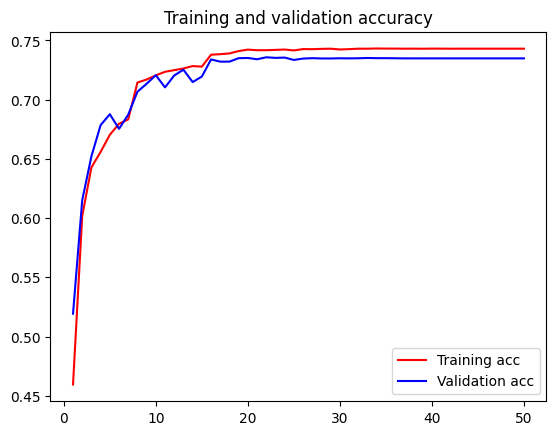

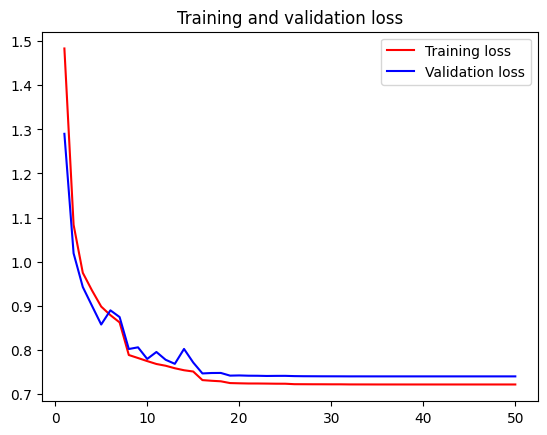

In [56]:
# Отримуємо дані про точність та втрати з історії тренування
acc = history_vgg16.history['acc']  # Точність на тренувальних даних
val_acc = history_vgg16.history['val_acc']  # Точність на валідаційних даних
loss = history_vgg16.history['loss']  # Втрати на тренувальних даних
val_loss = history_vgg16.history['val_loss']  # Втрати на валідаційних даних
epochs = range(1, len(acc) + 1)  # Створюємо список епох

# Графік точності на тренувальних та валідаційних даних
plt.title('Training and validation accuracy')  # Назва графіка
plt.plot(epochs, acc, 'red', label='Training acc')  # Точність тренування (червоним)
plt.plot(epochs, val_acc, 'blue', label='Validation acc')  # Точність валідації (синім)
plt.legend()  # Легенда

# Графік втрат на тренувальних та валідаційних даних
plt.figure()  # Створюємо нову фігуру для другого графіка
plt.title('Training and validation loss')  # Назва графіка
plt.plot(epochs, loss, 'red', label='Training loss')  # Втрати тренування (червоним)
plt.plot(epochs, val_loss, 'blue', label='Validation loss')  # Втрати валідації (синім)

# Легенда
plt.legend()

# Показуємо обидва графіки
plt.show()

## Модель багатошарова із попереднього завдання multi_layer_model для класифікації Fashion MNIST з використанням VGG16 як базової архітектури

In [57]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.regularizers import l2

# Завантаження датасету Fashion MNIST
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Переформатування зображень для використання в VGG16
x_train = tf.image.grayscale_to_rgb(tf.expand_dims(x_train, axis=-1))
x_test = tf.image.grayscale_to_rgb(tf.expand_dims(x_test, axis=-1))

x_train = tf.image.resize(x_train, (48, 48)) / 255.0
x_test = tf.image.resize(x_test, (48, 48)) / 255.0

# Завантаження VGG16 без верхнього рівня (fully connected layers)
vgg_base = VGG16(weights="imagenet", include_top=False, input_shape=(48, 48, 3))

# Замороження ваг VGG16
vgg_base.trainable = False

# Створення нової моделі з використанням VGG16
multi_layer_model_vgg16 = Sequential([
    # Вставка базової моделі VGG16
    vgg_base,

    # Додаємо GlobalAveragePooling замість Flatten для зменшення розмірів
    GlobalAveragePooling2D(),

    # Перший Dense шар з 384 нейронами та функцією активації ReLU
    Dense(384, activation='relu'),
    BatchNormalization(),  # Нормалізація
    Dropout(0.3),  # Dropout для запобігання перенавчанню

    # Другий Dense шар з 352 нейронами та функцією активації ReLU
    Dense(352, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Третій Dense шар з 352 нейронами та функцією активації ReLU
    Dense(352, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Вихідний шар: 10 нейронів для 10 класів
    Dense(10, activation='softmax')  # softmax для багатокласової класифікації
])

# Компіляція моделі
multi_layer_model_vgg16.compile(
    optimizer=Adam(learning_rate=0.0001),                   # learning rate = 0.0001
    loss=SparseCategoricalCrossentropy(from_logits=False),  # Функція втрат для багатокласової класифікації
    metrics=['accuracy']                                    # Метрика для моніторингу точності
)

# Виведення структури моделі
multi_layer_model_vgg16.summary()

# Колбеки
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Навчання моделі
history_multi_layer_model_vgg16 = multi_layer_model_vgg16.fit(
    x_train,
    y_train,
    epochs=50,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, reduce_lr]
)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 1, 1, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 384)                 │         196,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_44               │ (None, 384)                 │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_44 (Dropout)                 │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 352)                 │         135,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_45               │ (None, 352)                 │           1,408 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_45 (Dropout)                 │ (None, 352)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 352)                 │         124,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_46               │ (None, 352)                 │           1,408 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_46 (Dropout)                 │ (None, 352)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 10)                  │           3,530 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,179,338 (57.90 MB)

 Trainable params: 462,474 (1.76 MB)

 Non-trainable params: 14,716,864 (56.14 MB)

Epoch 1/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - accuracy: 0.6372 - loss: 1.1233 - val_accuracy: 0.8405 - val_loss: 0.4516 - learning_rate: 1.0000e-04
Epoch 2/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.7961 - loss: 0.5821 - val_accuracy: 0.8582 - val_loss: 0.3952 - learning_rate: 1.0000e-04
Epoch 3/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.8249 - loss: 0.4944 - val_accuracy: 0.8618 - val_loss: 0.3761 - learning_rate: 1.0000e-04
Epoch 4/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.8406 - loss: 0.4486 - val_accuracy: 0.8661 - val_loss: 0.3683 - learning_rate: 1.0000e-04
Epoch 5/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.8483 - loss: 0.4218 - val_accuracy: 0.8710 - val_loss: 0.3553 - learning_rate: 1.0000e-04
Epoch 6/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.8522 - loss: 0.4027 - val_accuracy: 0.8756 - val_loss: 0.3479 - learning_rate: 1.0000e-04
Epoch 7/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s

In [72]:
multi_layer_model_vgg16.save('multi_layer_model_vgg16.keras')

In [58]:
# Оцінка моделі на тестових даних
test_loss, test_acc = multi_layer_model_vgg16.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8956 - loss: 0.2983
Test accuracy: 0.8920999765396118
Test loss: 0.30762481689453125


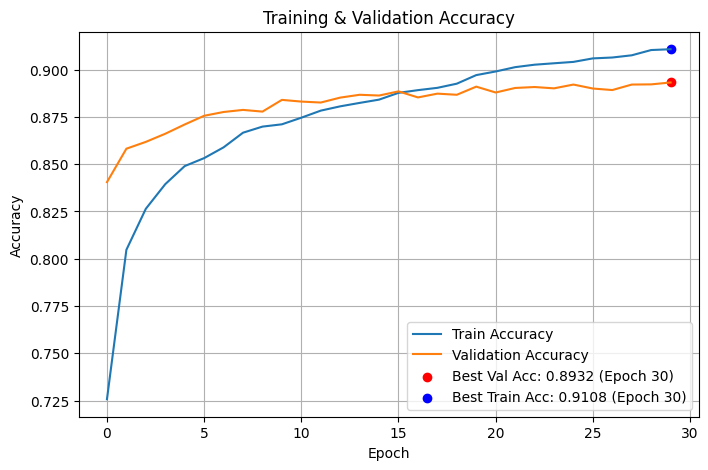

In [59]:
plot_accuracy(history_multi_layer_model_vgg16)

## Модель згорткова CNN_6 для класифікації Fashion MNIST з використанням VGG16 як базової архітектури

In [60]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.regularizers import l2

# Завантаження датасету Fashion MNIST
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Переформатування зображень для використання в VGG16
x_train = tf.image.grayscale_to_rgb(tf.expand_dims(x_train, axis=-1))
x_test = tf.image.grayscale_to_rgb(tf.expand_dims(x_test, axis=-1))

x_train = tf.image.resize(x_train, (48, 48)) / 255.0
x_test = tf.image.resize(x_test, (48, 48)) / 255.0

# Завантаження VGG16 без верхнього рівня (fully connected layers)
vgg_base = VGG16(weights="imagenet", include_top=False, input_shape=(48, 48, 3))

# Замороження ваг VGG16
vgg_base.trainable = False

# Побудова нової моделі
cnn_model_6_vgg16 = Sequential([
    vgg_base,

    GlobalAveragePooling2D(),

    Dense(384, activation="relu", kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(352, activation="relu", kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(352, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),

    Dense(10, activation="softmax")
])

# Компіляція моделі
cnn_model_6_vgg16.compile(
    optimizer=RMSprop(learning_rate=0.0001),
    loss=SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

# Виведення структури моделі
cnn_model_6_vgg16.summary()

# Колбеки
early_stopping = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-6)

# Навчання моделі
history_cnn_model_6_vgg16 = cnn_model_6_vgg16.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=50,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, reduce_lr]
)

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 1, 1, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 384)                 │         196,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_47               │ (None, 384)                 │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_47 (Dropout)                 │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 352)                 │         135,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_48               │ (None, 352)                 │           1,408 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_48 (Dropout)                 │ (None, 352)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 352)                 │         124,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_49               │ (None, 352)                 │           1,408 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_49 (Dropout)                 │ (None, 352)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 10)                  │           3,530 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,179,338 (57.90 MB)

 Trainable params: 462,474 (1.76 MB)

 Non-trainable params: 14,716,864 (56.14 MB)

Epoch 1/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.5654 - loss: 1.7403 - val_accuracy: 0.8189 - val_loss: 0.8043 - learning_rate: 1.0000e-04
Epoch 2/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.7708 - loss: 0.9622 - val_accuracy: 0.8375 - val_loss: 0.6935 - learning_rate: 1.0000e-04
Epoch 3/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.7981 - loss: 0.8243 - val_accuracy: 0.8476 - val_loss: 0.6370 - learning_rate: 1.0000e-04
Epoch 4/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.8145 - loss: 0.7480 - val_accuracy: 0.8575 - val_loss: 0.5995 - learning_rate: 1.0000e-04
Epoch 5/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.8272 - loss: 0.6857 - val_accuracy: 0.8605 - val_loss: 0.5692 - learning_rate: 1.0000e-04
Epoch 6/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.8326 - loss: 0.6626 - val_accuracy: 0.8649 - val_loss: 0.5473 - learning_rate: 1.0000e-04
Epoch 7/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s

In [73]:
cnn_model_6_vgg16.save('cnn_model_6_vgg16.keras')

In [61]:
# Оцінка моделі на тестових даних
test_loss, test_acc = cnn_model_6_vgg16.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8899 - loss: 0.3543
Test accuracy: 0.8894000053405762
Test loss: 0.36020851135253906


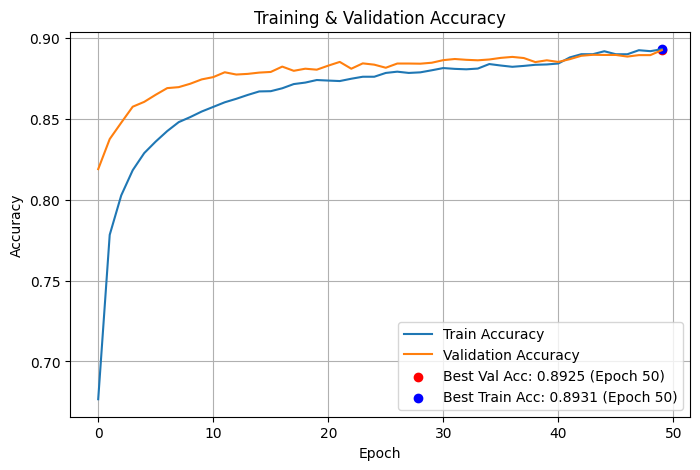

In [62]:
plot_accuracy(history_cnn_model_6_vgg16)

## Висновки щодо моделей

- CNN_Model_6 (CNN) показує найкращий баланс між тестовою (0.9308) і тренувальною (0.9306) точністю. Це свідчить про відмінну узагальнюючу здатність моделі без явного перенавчання.

- MLP (VGG16) має нижчу тестову точність (0.8958) у порівнянні з чистим CNN_Model_6, але тренувальна точність (0.9101) трохи вища. Це вказує на певне перенавчання і слабшу здатність узагальнювати нові дані.

- CNN_Model_6 (VGG16) демонструє найнижчу точність (0.8919 test, 0.8945 train). Це означає, що використання VGG16 у цьому випадку не дало переваг – модель не змогла досягти кращої точності, ніж оригінальна CNN_Model_6.

Підсумок:

- Найкращий вибір – CNN_Model_6 без VGG16. Вона демонструє найкращу тестову точність і стабільність.
- MLP (VGG16) – дещо перенавчена, що може викликати проблеми на нових даних.
- CNN_Model_6 (VGG16) не покращила результати, тому використання VGG16 тут неефективне.

Отже, CNN_Model_6 без VGG16 є найкращим варіантом, оскільки забезпечує найвищу тестову точність і найкраще узагальнення. 🚀